# load image sample

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import scipy

c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(256, 256, 3)


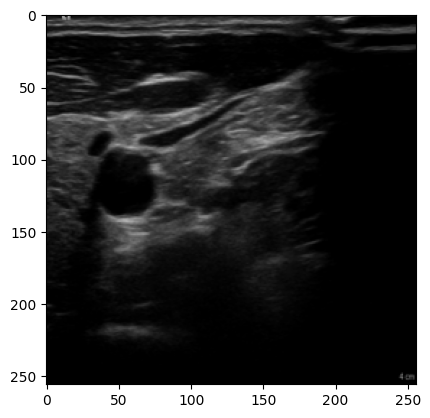

In [5]:
IMAGE_PATH = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/carotid_mutinfo/train/img0001.png"
image = np.array(Image.open(IMAGE_PATH).convert('RGB')) /255
image_np=np.array(image)
plt.imshow(image_np)
print(image_np.shape)

In [6]:
image_gr = np.array(Image.open(IMAGE_PATH).convert('L')) /255
image_gr=np.array(image_gr)

In [7]:
from extract_utils import reshape_split,ssd_patchwise_affinity_knn

In [8]:
from extract_utils import reshape_split_gr

In [9]:
W1, pathces = ssd_patchwise_affinity_knn(image_np, (64,64))

(0.0, 4.0)

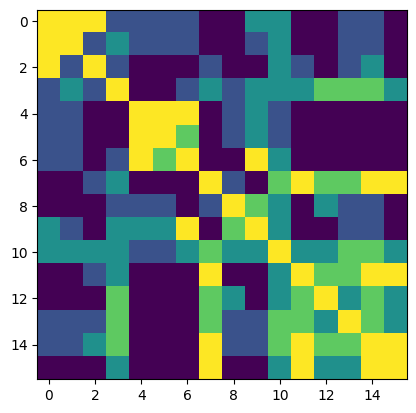

In [10]:
plt.imshow(W1)

np.min(W1), np.max(W1)

In [11]:
def var_patchwise_affinity_knn(image, patch_size, n_neighbors=[8, 4], distance_weights=[2.0, 0.1]):
  """
  Computes a SSD-based affinity matrix for patches of a single image.
  Note that this function requires pymattin and scipy.

  step 1 - split image into patches
  step 2 - calculate variance of each patch
  step 3 - calculate position arrays for distance weighing
  step 4 - apply knn approach, concatenating patch variances with weighted position arrays (different for diff distance weights)
  step 5 - assemble affinity matrix

  par: image - ndarray, of size compatible with the patch size, normalized
  par: patch_size - a tuple (patch_height, patch_width)
  
  based on: https://github.com/pymatting/pymatting/blob/master/pymatting/laplacian/knn_laplacian.py
  """
  try:
    from pymatting.util.kdtree import knn
  except:
        raise ImportError(
            'Please install pymatting to compute KNN affinity matrices:\n'
            'pip3 install pymatting'
        )
  
  patches=reshape_split(image, patch_size)
  
#   patches_2d = patches.reshape(patches.shape[0],-1)

#   n_patches=patches_2d.shape[0]
  n_patches = len(patches)
  n_height=image.shape[0]//patch_size[0]
  n_width=image.shape[1]//patch_size[1]

  var_patchwise = []  
  for p in patches:
    var_patchwise.append([np.var(p)])
  var_patchwise = np.array(var_patchwise)
  print(var_patchwise.shape)
  x = np.tile(np.linspace(0, 1, n_width), n_height)
  y = np.repeat(np.linspace(0, 1, n_height), n_width)

  i, j = [], []

  for k, distance_weight in zip(n_neighbors, distance_weights):
    xs=(distance_weight * x)[:, None]
    ys=(distance_weight * y)[:, None]
    f = np.concatenate((var_patchwise, xs, ys), axis = 1, dtype=np.float32)
    distances, neighbors = knn(f, f, k=k)
    i.append(np.repeat(np.arange(n_patches), k))
    j.append(neighbors.flatten())

  ij = np.concatenate(i + j)
  ji = np.concatenate(j + i)
  coo_data = np.ones(2 * sum(n_neighbors) * n_patches)

  # This is our affinity matrix
  W = scipy.sparse.csr_matrix((coo_data, (ij, ji)), (n_patches, n_patches)) 

  # Convert to dense numpy array
  W = np.array(W.todense().astype(np.float32))

  return W, patches


In [12]:
W2, pathces = var_patchwise_affinity_knn(image_np, (64,64))

(16, 1)


Text(0.5, 1.0, 'W_variance (incl pos)')

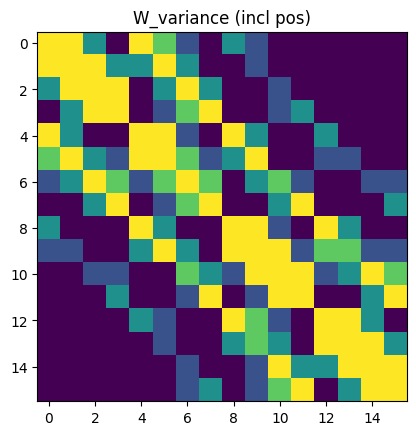

In [13]:
plt.imshow(W2)
plt.title("W_variance (incl pos)")

## USE OTHER SIMILARITY METRICS

In [14]:
from sklearn.metrics import mean_squared_error, normalized_mutual_info_score
# structural_similarity

In [15]:
# TODO check this for NCC https://dsp.stackexchange.com/questions/28322/python-normalized-cross-correlation-to-measure-similarites-in-2-images

In [16]:
normalized_mutual_info_score(image_gr.ravel(),image_gr.ravel())

c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


1.0

In [17]:
from skimage import io, feature
from scipy import ndimage
import numpy as np
# from scipy.ndimage import convolv

def correlation_coefficient(patch1, patch2):
    # ref: https://dsp.stackexchange.com/questions/28322/python-normalized-cross-correlation-to-measure-similarites-in-2-images
    mean1 = patch1.mean()
    mean2 = patch2.mean()
    
    var1 = patch1.var()
    var2 = patch2.var()
    
    covariance = np.mean((patch1 - mean1) * (patch2 - mean2))
    
    stds = np.sqrt(var1 * var2)
    
    if stds == 0:
        return 0
    else:
        product = covariance / stds
        return product

def correlation(im1, im2, d = 1):
    # print(im1.shape)
    sh_row, sh_col = im1.shape
    correlation = np.zeros_like(im1)

    for i in range(d, sh_row - (d + 1)):
        for j in range(d, sh_col - (d + 1)):
            correlation[i, j] = correlation_coefficient(im1[i - d: i + d + 1,
                                                            j - d: j + d + 1],
                                                        im2[i - d: i + d + 1,
                                                            j - d: j + d + 1])

    return correlation

def cc_distance(im1, im2, d=1):
    # https://discovery.ucl.ac.uk/id/eprint/1501070/1/paper888.pdf

    corr = correlation_coefficient(im1, im2)
    return 1 - corr

def lncc_distance(im1, im2, d=1, beta = 1.0):
    # ref: https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=B1E4384B47FF1D18B7B9F71B7D596843?doi=10.1.1.3.7938&rep=rep1&type=pdf
    corr = correlation(im1, im2, d)
    lncc = corr.sum()
    
    # Normalize the sum to the range [0, 1]
    # lncc_similarity = lncc / max_possible_sum
    lncc_similarity = lncc / corr.size
    return 1 - lncc_similarity

    

    



In [18]:
c = correlation_coefficient(image_gr, image_gr)
print(c)

c2 = cc_distance(image_gr,image_gr)
print(c2)

c3 = lncc_distance(image_gr,image_gr, 1)
print(c3)

1.0
0.0
0.286590576171875


In [19]:
corr = correlation(image_gr, image_gr, d = 1)
print(corr)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


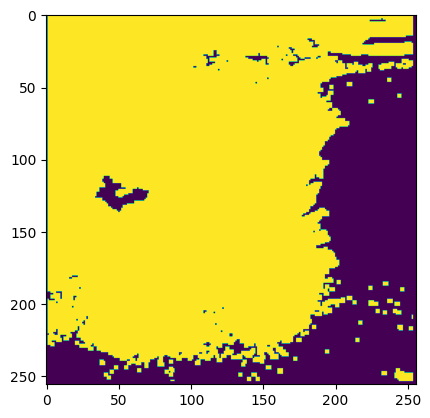

In [20]:
plt.imshow(corr)

## approximate your knn sdd patchwise afifnity, using a straightforward approach



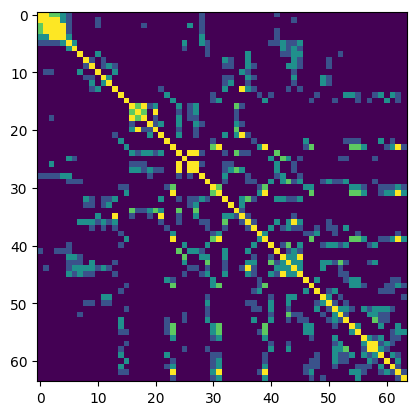

In [21]:
W1, pathces = ssd_patchwise_affinity_knn(image_np, (32,32), n_neighbors=[8,4], distance_weights=[0.0, 0.0])
plt.imshow(W1)

In [22]:
best_beta = None
best_similarity = float('inf')

for beta in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    affinity_matrix2 = patchwise_affinity(image_np, ssd, (32, 32), beta=beta)
    similarity = np.sum(np.abs(W1 - affinity_matrix2))  # Compute a similarity metric

    if similarity < best_similarity:
        best_similarity = similarity
        best_beta = beta

print("Best Beta:", best_beta)

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.imshow(affinity_matrix2)

In [ ]:
plt.imshow(W1)

In [23]:
def positional_patchwise_affinity_knn(image, patch_size, n_neighbors=[8, 4], distance_weights=[2.0, 0.1]):
  """
  Computes a SSD-based affinity matrix for patches of a single image.
  Note that this function requires pymattin and scipy.

  step 1 - split image into patches
  step 2 - flatten patches along x,y and ch dimensions -> results in shape (num_patches, rest)
  step 3 - calculate position arrays for distance weighing
  step 4 - apply knn approach, concatenating flattened patches with weighted position arrays (different for diff distance weights)
  step 5 - assemble affinity matrix

  par: image - ndarray, of size compatible with the patch size, normalized
  par: patch_size - a tuple (patch_height, patch_width)
  
  based on: https://github.com/pymatting/pymatting/blob/master/pymatting/laplacian/knn_laplacian.py
  """
  try:
    from pymatting.util.kdtree import knn
  except:
        raise ImportError(
            'Please install pymatting to compute KNN affinity matrices:\n'
            'pip3 install pymatting'
        )
  
  n_height=image.shape[0]//patch_size[0]
  n_width=image.shape[1]//patch_size[1]
  n_patches= n_height * n_width

  x = np.tile(np.linspace(0, 1, n_width), n_height)
  y = np.repeat(np.linspace(0, 1, n_height), n_width)

  i, j = [], []

  for k, distance_weight in zip(n_neighbors, distance_weights):
    xs=(distance_weight * x)[:, None]
    ys=(distance_weight * y)[:, None]
    f = np.concatenate((xs, ys), axis = 1, dtype=np.float32)
    distances, neighbors = knn(f, f, k=k)
    i.append(np.repeat(np.arange(n_patches), k))
    j.append(neighbors.flatten())

  ij = np.concatenate(i + j)
  ji = np.concatenate(j + i)
  coo_data = np.ones(2 * sum(n_neighbors) * n_patches)

  # This is our affinity matrix
  W = scipy.sparse.csr_matrix((coo_data, (ij, ji)), (n_patches, n_patches)) 

  # Convert to dense numpy array
  W = np.array(W.todense().astype(np.float32))

  return W

In [24]:
W_pos = positional_patchwise_affinity_knn(image_np, (64,64), n_neighbors=[8, 4], distance_weights=[2.0, 0.1])
# plt.imshow(W_pos)

In [25]:
W_ssd2, pathces = ssd_patchwise_affinity_knn(image_np, (64,64), n_neighbors=[8,4], distance_weights=[0.0, 0.0])
# plt.imshow(W_ssd2)

In [26]:
patch_size = (64, 64)
n_neighbors = [8, 4]
distance_weights = [2.0, 0.1]

# original SSD
W1, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only position
W_pos = positional_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only patches
W2, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])

# sum of only position and only patches
W3 = W_pos + W2

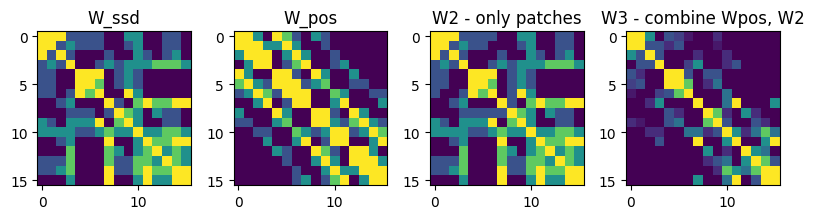

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(8, 8))

axs[0].imshow(W1)
axs[0].set_title("W_ssd")

axs[1].imshow(W_pos)
axs[1].set_title("W_pos")

axs[2].imshow(W2)
axs[2].set_title("W2 - only patches")

axs[3].imshow(W_pos*W2)
axs[3].set_title("W3 - combine Wpos, W2")

plt.tight_layout()
# plt.show()

## other similairty metrics

In [28]:
def ssd(im1, im2):
    return np.sum((im1-im2)**2)

def norm_data(data):
    """
    normalize data to have mean=0 and standard_deviation=1
    """
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    #return (data-mean_data)/(std_data*np.sqrt(data.size-1))
    return (data-mean_data)/(std_data)


def ncc(data0, data1):
    """
    normalized cross-correlation coefficient between two data sets

    Parameters
    ----------
    data0, data1 :  numpy arrays of same size
    """

    sym = (1.0/(data0.size-1)) * np.sum(norm_data(data0)*norm_data(data1))
    return sym

def ncc_distance(data0, data1):
    """
    normalized cross-correlation coefficient between two data sets

    Parameters
    ----------
    data0, data1 :  numpy arrays of same size
    """

    sym = (1.0/(data0.size-1)) * np.sum(norm_data(data0)*norm_data(data1))
    return 1 - sym

In [29]:
import scipy.sparse

def patchwise_affinity(image, similarity_measure, patch_size, beta=5.0):
    """
    Computes an SSD-based affinity matrix for patches of a single image.

    Args:
    - image (numpy.ndarray): The input image.
    - similarity_measure: a function takin gin 2 images, return a single value for the similarity score
    - patch_size (tuple): The size of the image patches.

    Returns:
    - affinity_matrix (numpy.ndarray): The computed affinity matrix.
    """
    patches = reshape_split_gr(image, patch_size)

    n_patches = len(patches)
    # Calculate pairwise similarities between all patches
    pairwise_sims = np.array([similarity_measure(p1, p2) for p1 in patches for p2 in patches])

    # normalize
    # pairwise_sims = (pairwise_sims-np.min(pairwise_sims))/(np.max(pairwise_sims)-np.min(pairwise_sims))

    # Reshape the 1D array of pairwise similarities into a square affinity matrix
    pairwise_sims = pairwise_sims.reshape(n_patches, n_patches)

    # Calculate the affinity matrix using the Gaussian Kernel
    affinity_matrix = np.exp(-beta * pairwise_sims)
    return affinity_matrix

# SSD

In [30]:
patch_size = (64, 64)
n_neighbors = [8, 4]
distance_weights = [2.0, 0.1]

# original SSD
W1, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only position
W_pos = positional_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only patches
W2, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])

# simplfied patch similarity using SSD
W4 = patchwise_affinity(image_gr, ssd, patch_size, 0.001)

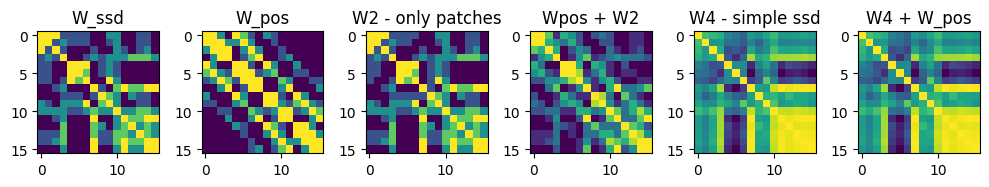

In [31]:
fig, axs = plt.subplots(1, 6, figsize=(10, 10))

axs[0].imshow(W1)
axs[0].set_title("W_ssd")

axs[1].imshow(W_pos)
axs[1].set_title("W_pos")

axs[2].imshow(W2)
axs[2].set_title("W2 - only patches")

axs[3].imshow(W_pos + W2)
axs[3].set_title("Wpos + W2")

axs[4].imshow(W4)
axs[4].set_title("W4 - simple ssd")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[5].imshow(W4)
axs[5].set_title("W4 + W_pos")


plt.tight_layout()
# plt.show()

In [32]:
best_beta = None
best_similarity = float('inf')

beta_values =  [0.001, 0.005, 0.01, 0.015, 0.02, 0.1, 1.0, 10.0, 100.0]
matrices = []

for beta in beta_values:
    affinity_matrix2 = patchwise_affinity(image_gr, ssd, (64, 64), beta=beta)
    similarity = np.sum(np.abs(W1 - affinity_matrix2))  # Compute a similarity metric

    matrices.append(affinity_matrix2)

    if similarity < best_similarity:
        best_similarity = similarity
        best_beta = beta

print("Best Beta:", best_beta)

Best Beta: 0.005


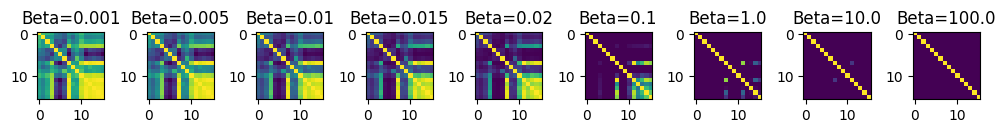

In [33]:
# Create a 2x2 grid of subplots within a single figure
fig, axs = plt.subplots(1, len(matrices), figsize=(10, 10))

# Now you have a 2x2 grid of subplots, and you can plot your images in each subplot
# For example, let's plot some random data in each subplot
for i in range(len(matrices)):
        axs[i].imshow(matrices[i])  # Replace some_image_data with your image data
        axs[i].set_title(f"Beta={beta_values[i]}")

# Adjust the spacing between subplots for better visibility
plt.tight_layout()

# Show the entire figure with all subplots
plt.show()

# NCC

In [34]:
patch_size = (64, 64)
n_neighbors = [8, 4]
distance_weights = [2.0, 0.1]

# original SSD
W1, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only position
W_pos = positional_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only patches
# W2, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])

# simplfied patch similarity using SSD
W5 = patchwise_affinity(image_gr, ncc_distance, (64,64), 0.1)


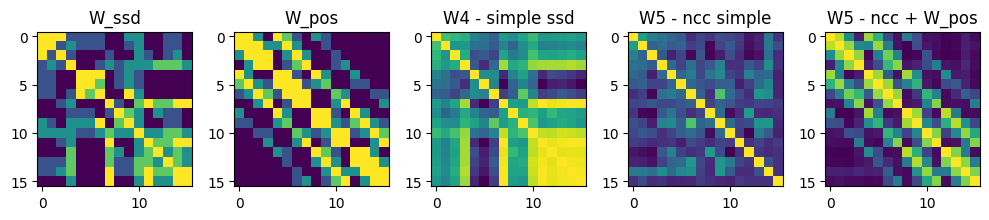

In [35]:

# PLOT
fig, axs = plt.subplots(1, 5, figsize=(10, 10))

axs[0].imshow(W1)
axs[0].set_title("W_ssd")

axs[1].imshow(W_pos)
axs[1].set_title("W_pos")

axs[2].imshow(W4)
axs[2].set_title("W4 - simple ssd")

axs[3].imshow(W5)
axs[3].set_title("W5 - ncc simple")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[4].imshow(W5 + 0.1* W_pos )
axs[4].set_title("W5 - ncc + W_pos")


plt.tight_layout()
# plt.show()

# LNCC

In [36]:
patch_size = (64, 64)
n_neighbors = [8, 4]
distance_weights = [2.0, 0.1]

# original SSD
W1, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only position
W_pos = positional_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)

# only patches
# W2, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])
W4 = patchwise_affinity(image_gr, ssd, patch_size, 0.01)


# simplfied patch similarity using SSD
W5 = patchwise_affinity(image_gr, ncc_distance, patch_size, 0.01)

W6 = patchwise_affinity(image_gr, cc_distance, patch_size, 0.01)

W7 = patchwise_affinity(image_gr, lncc_distance, patch_size, 0.01)







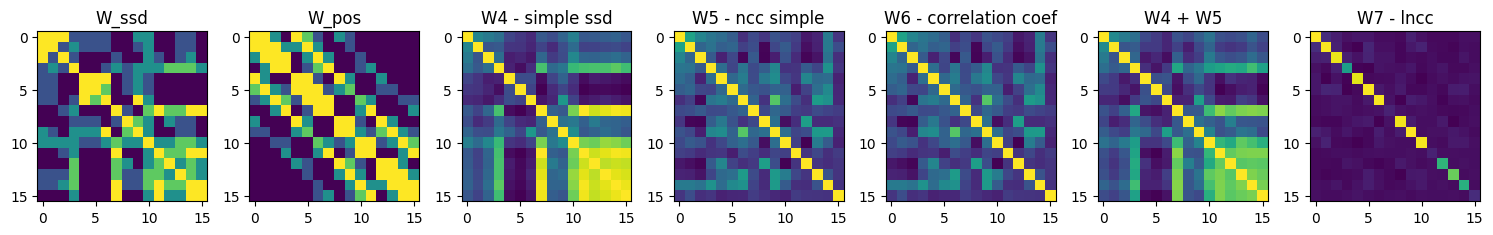

In [37]:

# PLOT
fig, axs = plt.subplots(1, 7, figsize=(15, 15))

axs[0].imshow(W1)
axs[0].set_title("W_ssd")

axs[1].imshow(W_pos)
axs[1].set_title("W_pos")

axs[2].imshow(W4)
axs[2].set_title("W4 - simple ssd")

axs[3].imshow(W5)
axs[3].set_title("W5 - ncc simple")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[4].imshow(W6 )
axs[4].set_title("W6 - correlation coef")

axs[5].imshow(W4* 0.05 + W5 )
axs[5].set_title("W4 + W5")

axs[6].imshow(W7)
axs[6].set_title("W7 - lncc")


plt.tight_layout()
# plt.show()

# SSIM

In [38]:
from skimage.metrics import structural_similarity as ssim

def ssim_distance(im1, im2):
    return 1 - ssim(im1, im2)

In [39]:
ssim_distance(image_gr, image_gr)

0.0

In [40]:
patch_size = (64, 64)
n_neighbors = [8, 4]
distance_weights = [2.0, 0.1]

# original SSD
W1, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)
W9, p = var_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])


# only position
W_pos = positional_patchwise_affinity_knn(image_gr, patch_size, n_neighbors, distance_weights)

# simplfied patch similarity using SSD
W5 = patchwise_affinity(image_gr, ncc, patch_size, 0.01)

W8 = patchwise_affinity(image_gr, ssim_distance, patch_size, .01)



(16, 1)


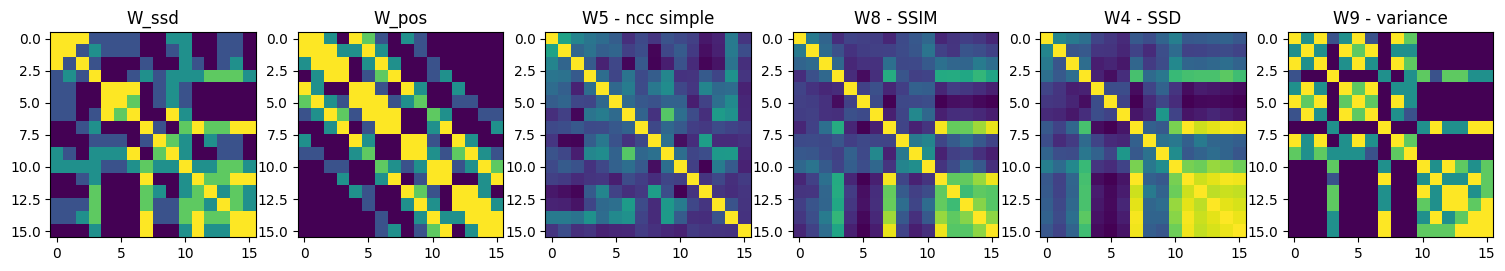

In [103]:

# PLOT
fig, axs = plt.subplots(1, 6, figsize=(15, 15))

axs[0].imshow(W1)
axs[0].set_title("W_ssd")

axs[1].imshow(W_pos)
axs[1].set_title("W_pos")



axs[2].imshow(W5)
axs[2].set_title("W5 - ncc simple")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[3].imshow(W8)
axs[3].set_title("W8 - SSIM")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[4].imshow(W4)
axs[4].set_title("W4 - SSD")

axs[5].imshow(W9)
axs[5].set_title("W9 - variance")



plt.tight_layout()
# plt.show()

# SEWAR LIBRARY METRICS

In [41]:
from sewar.full_ref import scc, msssim, sam
# ref: https://sewar.readthedocs.io/en/latest/#module-sewar.no_ref

def scc_distance(im1, im2):
    return 1 - scc(im1, im2)

def masssim_distance(im1, im2):
    return 1 - msssim(im1, im2)

# def sam_distance(im1, im2):
    # https://www.nv5geospatialsoftware.com/docs/SpectralAngleMapper.html
    # https://www.csr.utexas.edu/projects/rs/hrs/analysis.html
    # already is a distance, so no need to subtract from 1 
    # return 1 - sam(im1, im2)




In [43]:
# print(type(image_np), image_np.shape)
# scc_distance(image_np, image_np)
# sam_distance(image_gr, image_gr)


In [44]:
patch_size = (64, 64)
n_neighbors = [8, 4]
distance_weights = [2.0, 0.1]

# original SSD
W1, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, distance_weights)
W9, p = var_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])


# only position
W_pos = positional_patchwise_affinity_knn(image_gr, patch_size, n_neighbors, distance_weights)

# simplfied patch similarity using SSD
W5 = patchwise_affinity(image_gr, ncc, patch_size, .01)

W8 = patchwise_affinity(image_gr, ssim_distance, patch_size, .01)


W5 = patchwise_affinity(image_gr, ncc_distance, patch_size, .01)


W_scc = patchwise_affinity(image_gr, scc_distance, patch_size, .01)


(16, 1)


In [45]:
# W_scc = patchwise_affinity(image_gr, scc_distance, [16,16], .01)

# W_masssim = patchwise_affinity(image_np, masssim_distance, patch_size, .01)

W_sam = patchwise_affinity(image_gr, sam, patch_size, .01)

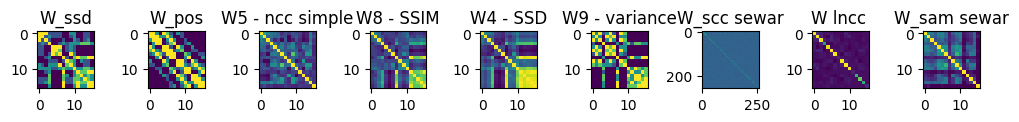

In [101]:

# PLOT
fig, axs = plt.subplots(1, 9, figsize=(10, 10))

axs[0].imshow(W1)
axs[0].set_title("W_ssd")

axs[1].imshow(W_pos)
axs[1].set_title("W_pos")



axs[2].imshow(W5)
axs[2].set_title("W5 - ncc simple")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[3].imshow(W8)
axs[3].set_title("W8 - SSIM")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[4].imshow(W4)
axs[4].set_title("W4 - SSD")

axs[5].imshow(W9)
axs[5].set_title("W9 - variance")

axs[6].imshow(W_scc)
axs[6].set_title("W_scc sewar")

axs[7].imshow(W7)
axs[7].set_title("W lncc ")

axs[8].imshow(W_sam)
axs[8].set_title("W_sam sewar")



plt.tight_layout()
# plt.show()

## Mutual Info

In [46]:
from sklearn.metrics import normalized_mutual_info_score

def mutual_info_distance(im1, im2):
    return 1 - normalized_mutual_info_score(im1.ravel(), im2.ravel())


In [47]:
patch_size = (64, 64)
n_neighbors = [8, 4]
distance_weights = [2.0, 0.1]

# original SSD
W_ssd_knn, p = ssd_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])
W_var_knn, p = var_patchwise_affinity_knn(image_np, patch_size, n_neighbors, [0.0, 0.0])

# only position
W_pos_knn = positional_patchwise_affinity_knn(image_gr, patch_size, n_neighbors, distance_weights)

# simplified patch affinities
W_ssd = patchwise_affinity(image_gr, ssd, patch_size, .01)
W_ncc = patchwise_affinity(image_gr, ncc_distance, patch_size, .01)
W_lncc = patchwise_affinity(image_gr, lncc_distance, patch_size, .01)
W_ssim = patchwise_affinity(image_gr, ssim_distance, patch_size, .01)
# W_mi = patchwise_affinity(image_gr, mutual_info_distance, patch_size, .01)
W_sam = patchwise_affinity(image_gr, sam, patch_size, .01)




(16, 1)


c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserW

In [48]:
W_mi = patchwise_affinity(image_gr*255, sam, patch_size, .01)

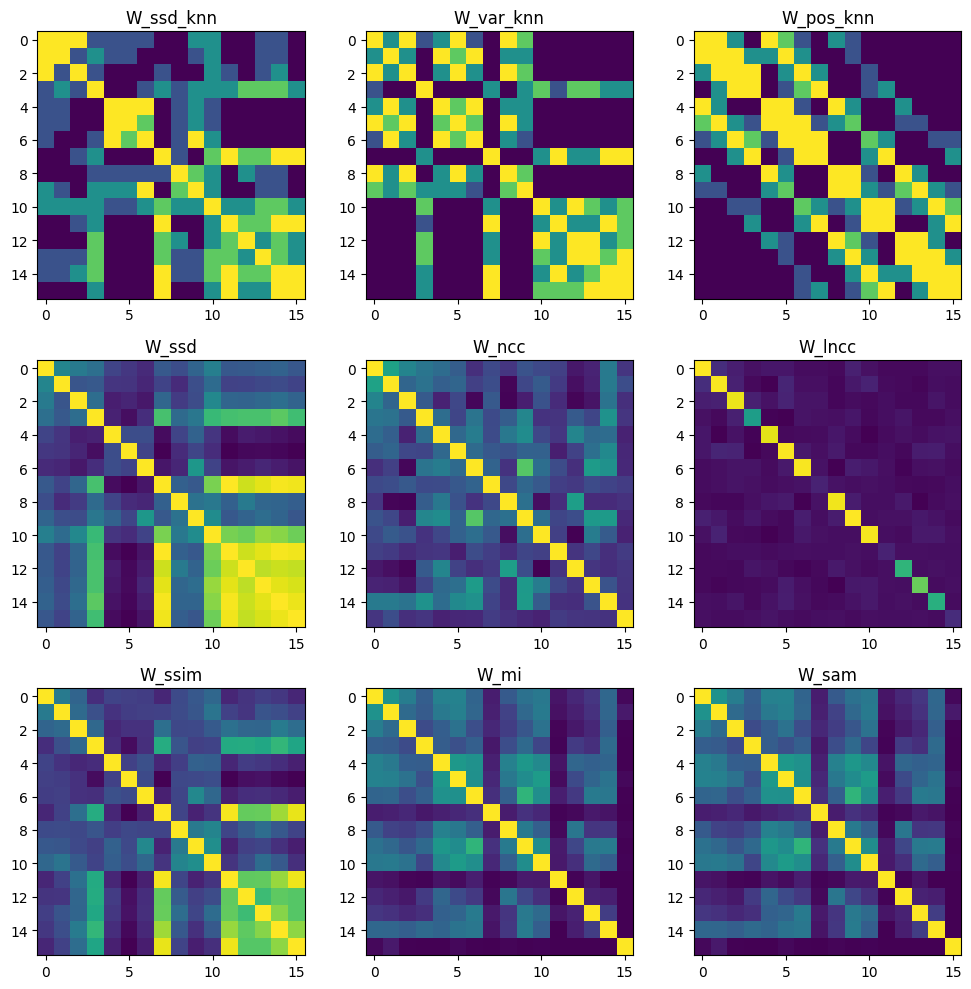

In [51]:

# PLOT
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

axs[0].imshow(W_ssd_knn)
axs[0].set_title("W_ssd_knn")

axs[1].imshow(W_var_knn)
axs[1].set_title("W_var_knn")



axs[2].imshow(W_pos_knn)
axs[2].set_title("W_pos_knn")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[3].imshow(W_ssd)
axs[3].set_title("W_ssd")

# axs[5].imshow(4* W4 + 0.1* W_pos)
axs[4].imshow(W_ncc)
axs[4].set_title("W_ncc")

axs[5].imshow(W_lncc)
axs[5].set_title("W_lncc")

axs[6].imshow(W_ssim)
axs[6].set_title("W_ssim")

axs[7].imshow(W_mi)
axs[7].set_title("W_mi")

axs[8].imshow(W_sam)
axs[8].set_title("W_sam")


plt.tight_layout()
# plt.show()

In [56]:
w1 = np.ones((5,5))
w2 = np.ones((5,5))
w3 = np.ones((5,5))

w_comb = (
    w1 * 1 +
    w2 * 2 +
    w3 * 3
)

w_comb


array([[6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.]])

In [57]:
type(w_comb)

numpy.ndarray

In [59]:

w_comb[0]

array([6., 6., 6., 6., 6.])

## TEMP - affinity config tests

In [66]:
sweep_dict = {
       
        "segments_num": {"values": [6, 8, 10, 12, 15, 18, 21]},
        'clusters_num': {"values": [5, 6, 7, 8, 9, 10]},

        "spectral_clustering":
        {
            'parameters': {
                'image_color_lambda': {'values': [0.0, 15.0]}
            }
        }

    }

parameters_dict = {'dataset': {'parameters': {'name': {'value': 'liver_mixed_val_mini'}, 'dataset_root': {'value': 'LIVER_MIXED/val_mini'}, 'input_size': {'value': 512}, 'images_root': {'value': 'images'}, 'list': {'value': 'lists/images.txt'}, 'gt_dir': {'value': 'labels'}, 'pred_dir': {'value': ''}, 'n_classes': {'value': 6}, 'n_clusters': {'value': None}, 'features_dir': {'value': None}, 'preprocessed_dir': {'value': 'preprocessed'}}}, 'wandb': {'parameters': {'setup': {'parameters': {'project': {'value': 'pipeline_eval'}, 'entity': {'value': 'alexaatm'}, 'mode': {'value': 'offline'}}}, 'key': {'value': ''}, 'tag': {'value': 'classNum_exp4'}, 'watch': {'parameters': {'log': {'value': 'all'}, 'log_freq': {'value': 1}}}, 'mode': {'value': 'local'}}}, 'loader': {'parameters': {'batch_size': {'value': 1}, 'num_workers': {'value': 0}, 'mode': {'value': 'full'}}}, 'model': {'parameters': {'name': {'value': 'dino_vits8'}, 'checkpoint': {'value': ''}}}, 'spectral_clustering': {'parameters': {'which_matrix': {'value': 'laplacian'}, 'which_color_matrix': {'value': 'knn'}, 'which_features': {'value': 'k'}, 'normalize': {'value': True}, 'threshold_at_zero': {'value': True}, 'lapnorm': {'value': True}, 'K': {'value': 5}, 'image_downsample_factor': {'value': None}, 'image_color_lambda': {'value': 0.0}, 'multiprocessing': {'value': 0}, 'image_ssd_beta': {'value': 1.0}, 'image_dino_gamma': {'value': 1.0}, 'max_knn_neigbors': {'value': 80}, 'image_var': {'value': 0.0}}}, 'multi_region_segmentation': {'parameters': {'adaptive': {'value': False}, 'non_adaptive_num_segments': {'value': 5}, 'infer_bg_index': {'value': True}, 'kmeans_baseline': {'value': False}, 'num_eigenvectors': {'value': 1000000}, 'multiprocessing': {'value': 0}}}, 'bbox': {'parameters': {'num_erode': {'value': 2}, 'num_dilate': {'value': 5}, 'skip_bg_index': {'value': True}, 'downsample_factor': {'value': 8}, 'num_clusters': {'value': 5}, 'seed': {'value': 1}, 'pca_dim': {'value': 0}}}, 'precomputed': {'parameters': {'mode': {'value': 'from_scratch'}, 'features': {'value': ''}, 'eig': {'value': ''}, 'multi_region_segmentation': {'value': ''}, 'bboxes': {'value': ''}, 'bbox_features': {'value': ''}, 'bbox_clusters': {'value': ''}, 'segmaps': {'value': ''}, 'crf_segmaps': {'value': ''}}}, 'crf': {'parameters': {'num_classes': {'value': 5}, 'downsample_factor': {'value': 8}, 'multiprocessing': {'value': 0}, 'w1': {'value': 10}, 'alpha': {'value': 80}, 'beta': {'value': 13}, 'w2': {'value': 3}, 'gamma': {'value': 3}, 'it': {'value': 5.0}}}, 'vis': {'parameters': {'eigen': {'value': False}, 'crf_segmaps': {'value': False}, 'dino_attn_maps': {'value': False}, 'multiregion_segmaps': {'value': False}, 'segmaps': {'value': False}, 'crf_multi_region': {'value': False}}}, 'pipeline_steps': {'parameters': {'dino_features': {'value': True}, 'eigen': {'value': True}, 'segments': {'value': True}, 'bbox': {'value': True}, 'bbox_features': {'value': True}, 'clusters': {'value': True}, 'sem_segm': {'value': True}, 'crf_segm': {'value': True}, 'crf_multi_region': {'value': True}, 'eval': {'value': True}}}, 'eval': {'parameters': {'vis_dir': {'value': './eval/vis'}, 'vis_rand_k': {'value': 10}, 'eval_per_image': {'value': True}, 'eval_per_dataset': {'value': False}, 'iou_thresh': {'value': 0.0}, 'void_label': {'value': 0}}}, 'custom_path_to_save_data': {'value': ''}, 'only_vis': {'value': False}, 'only_eval': {'value': False}, 'preprocessed_data': {'value': False}, 'norm': {'value': 'imagenet'}, 'segments_num': {'max': 30, 'min': 10}, 'clusters_num': {'values': [5, 6, 7, 8, 9, 10]}}

sweep_dict, parameters_dict

({'segments_num': {'values': [6, 8, 10, 12, 15, 18, 21]},
  'clusters_num': {'values': [5, 6, 7, 8, 9, 10]}},
 {'dataset': {'parameters': {'name': {'value': 'liver_mixed_val_mini'},
    'dataset_root': {'value': 'LIVER_MIXED/val_mini'},
    'input_size': {'value': 512},
    'images_root': {'value': 'images'},
    'list': {'value': 'lists/images.txt'},
    'gt_dir': {'value': 'labels'},
    'pred_dir': {'value': ''},
    'n_classes': {'value': 6},
    'n_clusters': {'value': None},
    'features_dir': {'value': None},
    'preprocessed_dir': {'value': 'preprocessed'}}},
  'wandb': {'parameters': {'setup': {'parameters': {'project': {'value': 'pipeline_eval'},
      'entity': {'value': 'alexaatm'},
      'mode': {'value': 'offline'}}},
    'key': {'value': ''},
    'tag': {'value': 'classNum_exp4'},
    'watch': {'parameters': {'log': {'value': 'all'},
      'log_freq': {'value': 1}}},
    'mode': {'value': 'local'}}},
  'loader': {'parameters': {'batch_size': {'value': 1},
    'num_work

In [69]:
 for key, value in sweep_dict.items():
    print('key=', key, 'value=', value)
    if key in parameters_dict:
        print(f"key {key} is in parameters_dict!")
        print(f"keys of sweep_dict[key]={sweep_dict[key].keys()}")
        if 'parameters' in sweep_dict[key].keys():
            print(f"key 'parameters' is in sweep_dict[key]!")
            parameters_dict[key]['parameters'].update(value['parameters'])
        else:
            print(f"substitute directly!")
            parameters_dict[key] = value

key= segments_num value= {'values': [6, 8, 10, 12, 15, 18, 21]}
key segments_num is in parameters_dict!
keys of sweep_dict[key]=dict_keys(['values'])
substitute directly!
key= clusters_num value= {'values': [5, 6, 7, 8, 9, 10]}
key clusters_num is in parameters_dict!
keys of sweep_dict[key]=dict_keys(['values'])
substitute directly!


In [70]:
parameters_dict

{'dataset': {'parameters': {'name': {'value': 'liver_mixed_val_mini'},
   'dataset_root': {'value': 'LIVER_MIXED/val_mini'},
   'input_size': {'value': 512},
   'images_root': {'value': 'images'},
   'list': {'value': 'lists/images.txt'},
   'gt_dir': {'value': 'labels'},
   'pred_dir': {'value': ''},
   'n_classes': {'value': 6},
   'n_clusters': {'value': None},
   'features_dir': {'value': None},
   'preprocessed_dir': {'value': 'preprocessed'}}},
 'wandb': {'parameters': {'setup': {'parameters': {'project': {'value': 'pipeline_eval'},
     'entity': {'value': 'alexaatm'},
     'mode': {'value': 'offline'}}},
   'key': {'value': ''},
   'tag': {'value': 'classNum_exp4'},
   'watch': {'parameters': {'log': {'value': 'all'},
     'log_freq': {'value': 1}}},
   'mode': {'value': 'local'}}},
 'loader': {'parameters': {'batch_size': {'value': 1},
   'num_workers': {'value': 0},
   'mode': {'value': 'full'}}},
 'model': {'parameters': {'name': {'value': 'dino_vits8'},
   'checkpoint': {'v